In [1]:
# MASTER SETUP

print("Setting up...")

import torch
!pip install -q transformers scikit-learn matplotlib seaborn pandas numpy textstat

from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import StandardScaler
import os
import re
from collections import Counter
import string

project_dir = '/content/drive/MyDrive/ai_detection_project'
os.chdir(project_dir)

print(f" Setup complete")

Setting up...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 40.0 MB/s eta 0:00:00
Mounted at /content/drive
 Setup complete


In [2]:
# LOAD DATASET

print("Loading dataset...")

df = pd.read_csv('data/dataset_with_perplexity.csv')

print(f"Total samples: {len(df)}")
print(f"Human: {len(df[df['label']=='human'])}")
print(f"AI: {len(df[df['label']=='ai'])}")

df['label_numeric'] = (df['label'] == 'ai').astype(int)

Loading dataset...
Total samples: 1052
Human: 457
AI: 595


In [3]:
# EXTRACT STATISTICAL FEATURES

print("Extracting statistical features...")

def extract_features(text):
    """Extract 20+ statistical features from text"""

    # Basic counts
    words = text.split()
    sentences = re.split(r'[.!?]+', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    # Character-level features
    char_count = len(text)
    alpha_count = sum(c.isalpha() for c in text)
    digit_count = sum(c.isdigit() for c in text)
    space_count = sum(c.isspace() for c in text)
    punct_count = sum(c in string.punctuation for c in text)
    upper_count = sum(c.isupper() for c in text)

    # Word-level features
    word_count = len(words)
    unique_words = len(set(words))
    avg_word_length = np.mean([len(w) for w in words]) if words else 0

    # Sentence-level features
    sentence_count = len(sentences)
    avg_sentence_length = word_count / sentence_count if sentence_count > 0 else 0
    sentence_length_variance = np.var([len(s.split()) for s in sentences]) if len(sentences) > 1 else 0

    # Lexical diversity
    lexical_diversity = unique_words / word_count if word_count > 0 else 0

    # Punctuation ratios
    punct_ratio = punct_count / char_count if char_count > 0 else 0
    comma_count = text.count(',')
    period_count = text.count('.')
    question_count = text.count('?')
    exclamation_count = text.count('!')

    # Word frequency (burstiness)
    word_freq = Counter(words)
    word_freq_variance = np.var(list(word_freq.values())) if word_freq else 0

    # Stopwords (common words)
    stopwords = {'the', 'be', 'to', 'of', 'and', 'a', 'in', 'that', 'have', 'i',
                 'it', 'for', 'not', 'on', 'with', 'he', 'as', 'you', 'do', 'at'}
    stopword_count = sum(1 for w in words if w.lower() in stopwords)
    stopword_ratio = stopword_count / word_count if word_count > 0 else 0

    # Transition words (AI tends to use more)
    transition_words = {'however', 'therefore', 'furthermore', 'moreover', 'additionally',
                       'consequently', 'thus', 'hence', 'nevertheless', 'nonetheless'}
    transition_count = sum(1 for w in words if w.lower() in transition_words)
    transition_ratio = transition_count / word_count if word_count > 0 else 0

    # Personal pronouns (humans use more)
    personal_pronouns = {'i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours'}
    pronoun_count = sum(1 for w in words if w.lower() in personal_pronouns)
    pronoun_ratio = pronoun_count / word_count if word_count > 0 else 0

    return {
        'char_count': char_count,
        'word_count': word_count,
        'sentence_count': sentence_count,
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length,
        'sentence_length_variance': sentence_length_variance,
        'lexical_diversity': lexical_diversity,
        'unique_word_ratio': unique_words / word_count if word_count > 0 else 0,
        'punct_ratio': punct_ratio,
        'comma_ratio': comma_count / char_count if char_count > 0 else 0,
        'period_ratio': period_count / char_count if char_count > 0 else 0,
        'question_ratio': question_count / char_count if char_count > 0 else 0,
        'upper_ratio': upper_count / alpha_count if alpha_count > 0 else 0,
        'digit_ratio': digit_count / char_count if char_count > 0 else 0,
        'stopword_ratio': stopword_ratio,
        'transition_ratio': transition_ratio,
        'pronoun_ratio': pronoun_ratio,
        'word_freq_variance': word_freq_variance,
    }

features_list = []

for idx, row in df.iterrows():
    features = extract_features(row['text'])
    features_list.append(features)

    if (idx + 1) % 200 == 0:
        print(f"  Processed {idx + 1}/{len(df)}")

features_df = pd.DataFrame(features_list)

print(f"\n Extracted {len(features_df.columns)} features")
print(f"\nFeatures: {list(features_df.columns)}")

Extracting statistical features...
  Processed 200/1052
  Processed 400/1052
  Processed 600/1052
  Processed 800/1052
  Processed 1000/1052

 Extracted 18 features

Features: ['char_count', 'word_count', 'sentence_count', 'avg_word_length', 'avg_sentence_length', 'sentence_length_variance', 'lexical_diversity', 'unique_word_ratio', 'punct_ratio', 'comma_ratio', 'period_ratio', 'question_ratio', 'upper_ratio', 'digit_ratio', 'stopword_ratio', 'transition_ratio', 'pronoun_ratio', 'word_freq_variance']


In [4]:
# COMBINE FEATURES WITH LABELS

print("Combining features with labels...")

df_features = pd.concat([df[['text', 'label', 'label_numeric']], features_df], axis=1)

print(f"\nDataset shape: {df_features.shape}")
print(f"Features: {len(features_df.columns)}")

df_features.to_csv('data/dataset_with_features.csv', index=False)
print("Saved dataset with features")

Combining features with labels...

Dataset shape: (1052, 21)
Features: 18
Saved dataset with features


Analyzing which features differ most between human/AI...

Top 10 Most Discriminative Features:
                 Feature  Human_Mean    AI_Mean  Difference    Ratio
sentence_length_variance   64.274002 481.645154  417.371152 0.133447
     avg_sentence_length   20.895992  31.491791   10.595798 0.663538
              char_count  821.759300 812.099160    9.660140 1.011895
              word_count  124.100656 115.045378    9.055278 1.078710
          sentence_count    6.221007   4.566387    1.654620 1.362348
         avg_word_length    5.464641   5.908281    0.443640 0.924912
      word_freq_variance    1.316345   1.510211    0.193866 0.871630
       lexical_diversity    0.751733   0.715450    0.036283 1.050714
       unique_word_ratio    0.751733   0.715450    0.036283 1.050714
           pronoun_ratio    0.029331   0.004978    0.024353 5.892557


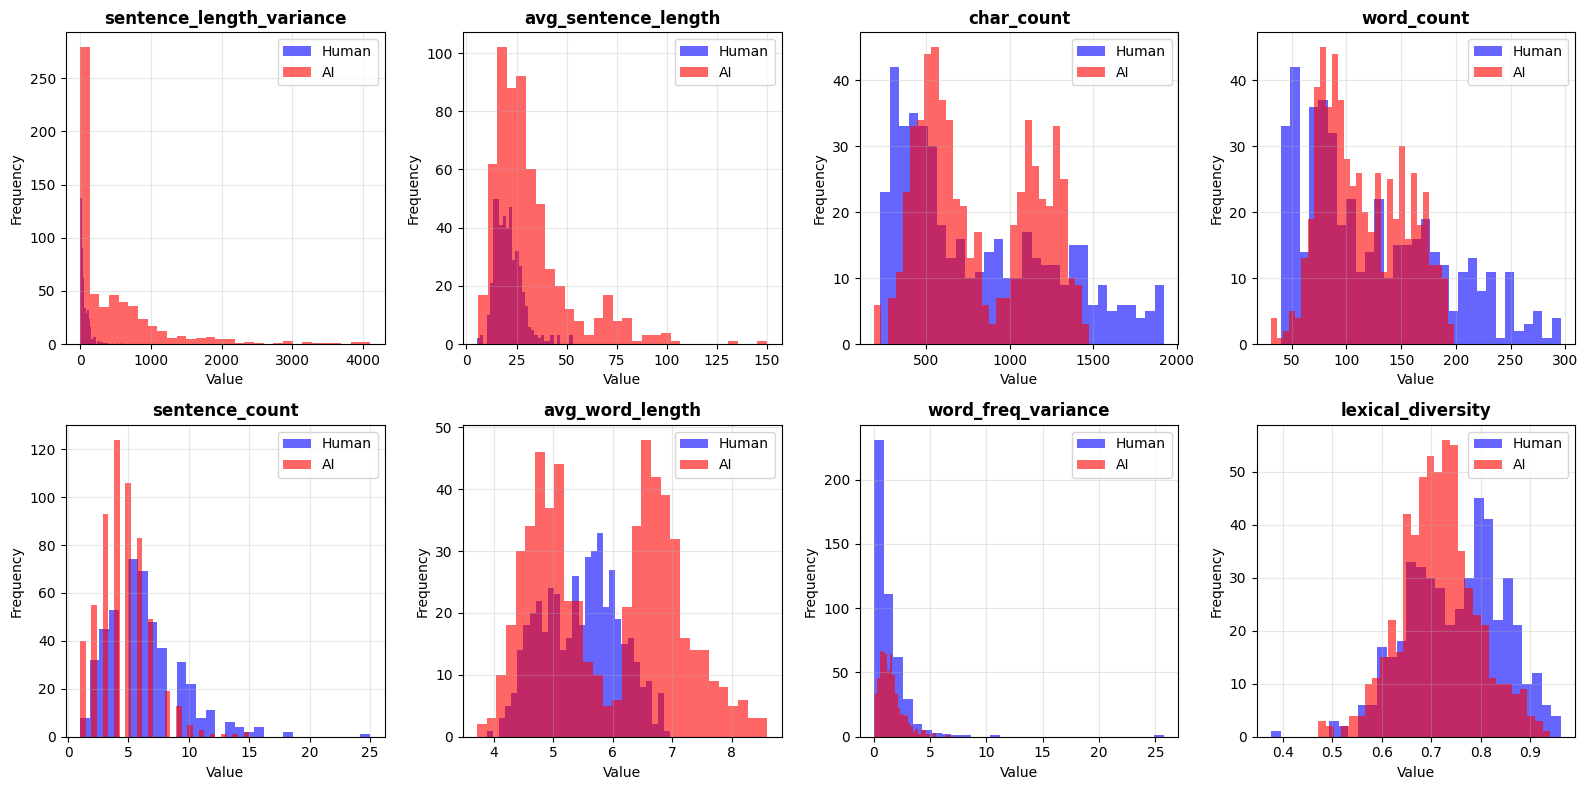


 Feature analysis complete


In [5]:
# ANALYZE FEATURE IMPORTANCE

print("Analyzing which features differ most between human/AI...\n")

human_features = features_df[df['label']=='human']
ai_features = features_df[df['label']=='ai']

feature_comparison = pd.DataFrame({
    'Feature': features_df.columns,
    'Human_Mean': human_features.mean(),
    'AI_Mean': ai_features.mean(),
})

feature_comparison['Difference'] = abs(feature_comparison['Human_Mean'] - feature_comparison['AI_Mean'])
feature_comparison['Ratio'] = feature_comparison['Human_Mean'] / (feature_comparison['AI_Mean'] + 1e-10)
feature_comparison = feature_comparison.sort_values('Difference', ascending=False)

print("Top 10 Most Discriminative Features:")
print(feature_comparison.head(10).to_string(index=False))

# Visualize top features
top_features = feature_comparison.head(8)['Feature'].values

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    ax = axes[idx]
    ax.hist(human_features[feature], bins=30, alpha=0.6, label='Human', color='blue')
    ax.hist(ai_features[feature], bins=30, alpha=0.6, label='AI', color='red')
    ax.set_title(feature, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('results/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Feature analysis complete")

In [6]:
# TRAIN/TEST SPLIT

print("Splitting data...")

X = features_df.values
y = df['label_numeric'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {len(X_train)} samples")
print(f"Test: {len(X_test)} samples")
print(f"Features: {X_train.shape[1]}")

Splitting data...
Train: 841 samples
Test: 211 samples
Features: 18


In [7]:
# TRAIN MULTIPLE CLASSIFIERS

print("Training multiple classifiers...\n")

classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
}

results = {}

for name, clf in classifiers.items():
    print(f"Training {name}...")

    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'model': clf
    }

    print(f"  Accuracy: {acc:.3f}")
    print(f"  F1 Score: {f1:.3f}\n")

# Find best model
best_model_name = max(results, key=lambda x: results[x]['f1'])
best_model = results[best_model_name]['model']

print(f" Best model: {best_model_name}")
print(f" F1 Score: {results[best_model_name]['f1']:.3f}")

Training multiple classifiers...

Training Logistic Regression...
  Accuracy: 0.867
  F1 Score: 0.885

Training Random Forest...
  Accuracy: 0.938
  F1 Score: 0.944

Training Gradient Boosting...
  Accuracy: 0.929
  F1 Score: 0.936

 Best model: Random Forest
 F1 Score: 0.944


Evaluating Random Forest in detail...

Performance Metrics:
              precision    recall  f1-score   support

       Human       0.91      0.96      0.93        92
          AI       0.96      0.92      0.94       119

    accuracy                           0.94       211
   macro avg       0.94      0.94      0.94       211
weighted avg       0.94      0.94      0.94       211


Confusion Matrix:
  True Negatives:  88
  False Positives: 4
  False Negatives: 9
  True Positives:  110


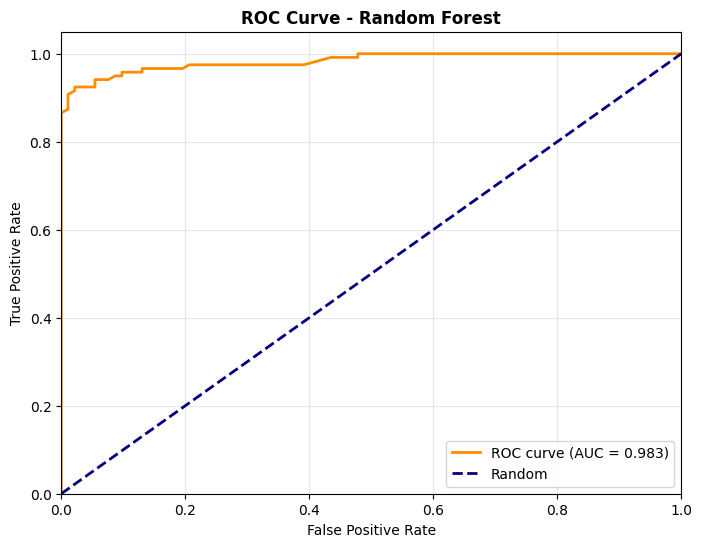


 AUC Score: 0.983


In [8]:
# DETAILED EVALUATION

print(f"Evaluating {best_model_name} in detail...\n")

y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

print("Performance Metrics:")
print(classification_report(y_test, y_pred, target_names=['Human', 'AI']))

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {tn}")
print(f"  False Positives: {fp}")
print(f"  False Negatives: {fn}")
print(f"  True Positives:  {tp}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}', fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig('results/roc_curve_statistical.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n AUC Score: {roc_auc:.3f}")

Analyzing feature importance...

Top 10 Most Important Features:
                 Feature  Importance
           pronoun_ratio    0.167521
sentence_length_variance    0.118102
            period_ratio    0.090740
              word_count    0.080942
         avg_word_length    0.078928
              char_count    0.074300
       lexical_diversity    0.071276
          stopword_ratio    0.058535
       unique_word_ratio    0.056749
             punct_ratio    0.054874


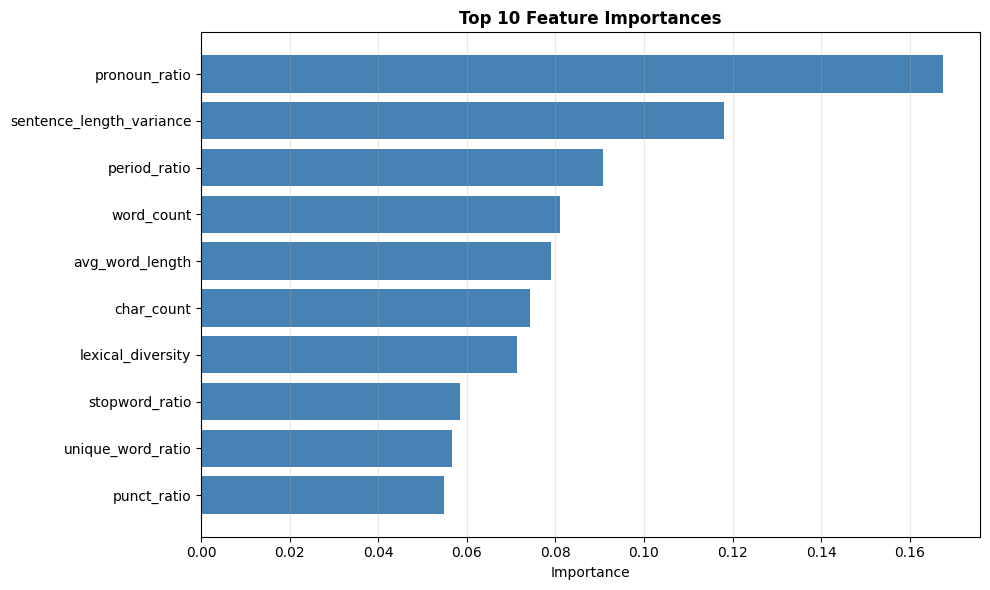

In [9]:
# FEATURE IMPORTANCE

print("Analyzing feature importance...\n")

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_names = features_df.columns

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print("Top 10 Most Important Features:")
    print(feature_importance_df.head(10).to_string(index=False))

    plt.figure(figsize=(10, 6))
    top_10 = feature_importance_df.head(10)
    plt.barh(range(len(top_10)), top_10['Importance'], color='steelblue')
    plt.yticks(range(len(top_10)), top_10['Feature'])
    plt.xlabel('Importance')
    plt.title('Top 10 Feature Importances', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(alpha=0.3, axis='x')
    plt.tight_layout()
    plt.savefig('results/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("Feature importance not available for this model")

In [10]:
# SAVE MODEL AND RESULTS

print("Saving model and results...")

import pickle

model_data = {
    'model': best_model,
    'scaler': scaler,
    'feature_names': list(features_df.columns),
    'best_model_name': best_model_name,
    'results': results[best_model_name]
}

with open('models/statistical_detector.pkl', 'wb') as f:
    pickle.dump(model_data, f)

results_summary = {
    'method': 'Statistical Features',
    'best_model': best_model_name,
    'accuracy': results[best_model_name]['accuracy'],
    'precision': results[best_model_name]['precision'],
    'recall': results[best_model_name]['recall'],
    'f1': results[best_model_name]['f1'],
    'auc': roc_auc,
    'num_features': X_train.shape[1],
}

import json
with open('results/statistical_detector_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print(" Model and results saved")
print("\n")
print("STATISTICAL DETECTOR SUMMARY")
print(f"Best Model: {best_model_name}")
print(f"Accuracy:  {results[best_model_name]['accuracy']:.1%}")
print(f"Precision: {results[best_model_name]['precision']:.1%}")
print(f"Recall:    {results[best_model_name]['recall']:.1%}")
print(f"F1 Score:  {results[best_model_name]['f1']:.3f}")
print(f"AUC:       {roc_auc:.3f}")

Saving model and results...
 Model and results saved


STATISTICAL DETECTOR SUMMARY
Best Model: Random Forest
Accuracy:  93.8%
Precision: 96.5%
Recall:    92.4%
F1 Score:  0.944
AUC:       0.983
